<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/image_classification/mlp_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and visualize dataset

In [1]:
# import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_x = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_x = datasets.MNIST(root="data", train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
# percentage of training set to use as validation
valid_size = 0.2

# split dataset into train and test datasets 
m = len(train_x) # num of training examples
indices = list(range(m))
np.random.shuffle(indices)
split = int(np.floor(valid_size * m))
train_idx, valid_idx = indices[split:], indices[:split]

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_x, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_x, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_x, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

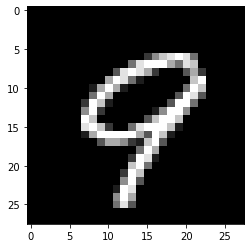

In [7]:
# visualize a training example
img = np.squeeze(images[1])
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

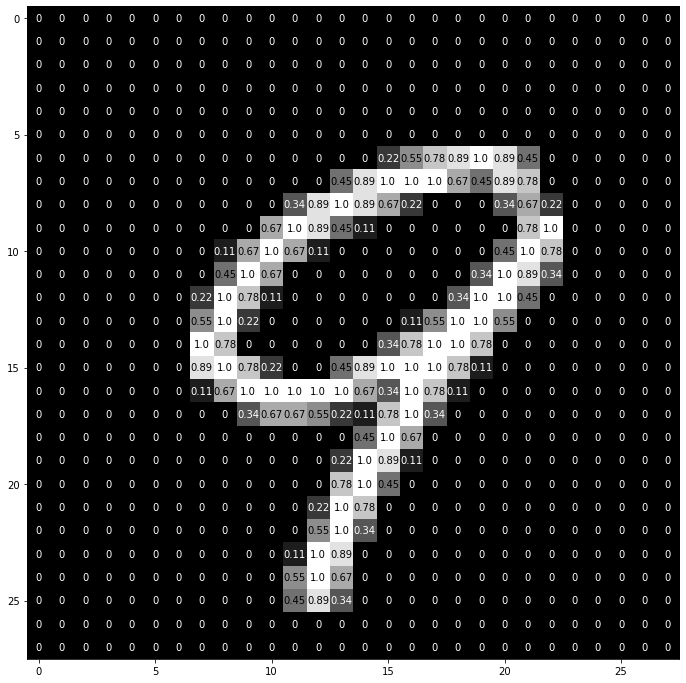

In [8]:
# visualize an example in more detail
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

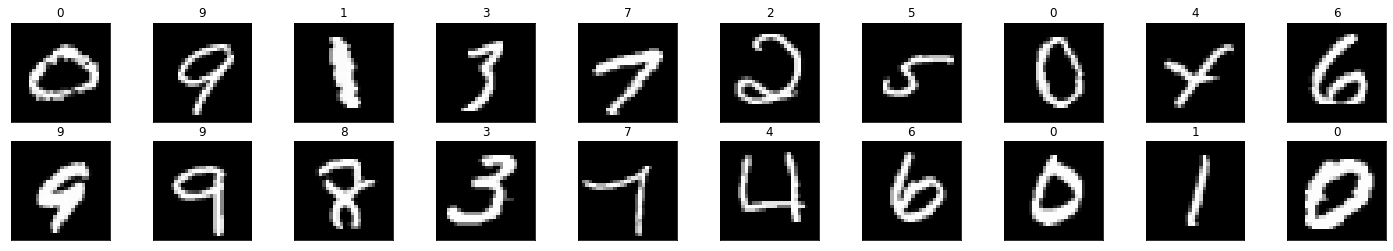

In [9]:
# plot a batch of training images along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[i]), cmap="gray")
  ax.set_title(str(labels[i].item()))

## Define a neural network

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# define the neural network architecture
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.fc1 = nn.Linear(28*28, 512) 
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 10)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x
  
model = Network()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [11]:
# specify loss (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Train the model

In [12]:
epochs = 20

# initialize trackers for min validation loss
min_valid_loss = np.inf

for epoch in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0

  # ---------------------
  # train the model
  # ---------------------
  # prepare model for training
  model.train()
  for X, y in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      X, y = X.cuda(), y.cuda()
    # clear the gradients of all optimized varibales
    optimizer.zero_grad()
    # forward pass
    pred_y = model(X)
    # calculate the loss
    loss = criterion(pred_y, y)
    # backward pass
    loss.backward()
    # optimization step to update parameters
    optimizer.step()

    train_loss += loss.item()

  # -----------------------
  # validate the model
  # -----------------------
  # prefer model for evaluation
  model.eval()
  for X, y in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      X, y = X.cuda(), y.cuda()
    # forward pass
    pred_y = model(X)
    # calculate loss
    loss = criterion(pred_y, y)
    
    valid_loss += loss.item()


  #------------------------
  # training/ validation statistics
  # -----------------------
  # calculate average loss over an epoch
  train_loss = train_loss / len(train_loader)
  valid_loss = valid_loss / len(valid_loader)

  print("Epoch: {} \tTraining loss: {:.6f}  \tValidation loss: {:.6f}".format(epoch+1, train_loss, valid_loss))

  # save model if validation loss has decreased
  if valid_loss <= min_valid_loss:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      min_valid_loss,
      valid_loss))
      
      torch.save(model.state_dict(), 'model.pt')
      min_valid_loss = valid_loss

Epoch: 1 	Training loss: 0.943469  	Validation loss: 0.369268
Validation loss decreased (inf --> 0.369268).  Saving model ...
Epoch: 2 	Training loss: 0.357445  	Validation loss: 0.280558
Validation loss decreased (0.369268 --> 0.280558).  Saving model ...
Epoch: 3 	Training loss: 0.281143  	Validation loss: 0.233261
Validation loss decreased (0.280558 --> 0.233261).  Saving model ...
Epoch: 4 	Training loss: 0.233180  	Validation loss: 0.197305
Validation loss decreased (0.233261 --> 0.197305).  Saving model ...
Epoch: 5 	Training loss: 0.200710  	Validation loss: 0.173077
Validation loss decreased (0.197305 --> 0.173077).  Saving model ...
Epoch: 6 	Training loss: 0.173973  	Validation loss: 0.150803
Validation loss decreased (0.173077 --> 0.150803).  Saving model ...
Epoch: 7 	Training loss: 0.152856  	Validation loss: 0.134897
Validation loss decreased (0.150803 --> 0.134897).  Saving model ...
Epoch: 8 	Training loss: 0.137783  	Validation loss: 0.123899
Validation loss decreased 

In [13]:
# load model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Evaluate the performance of the trained model on a test dataset